In [1]:
import requests
import json

import pandas as pd
from pandas.tseries.frequencies import to_offset

import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import time
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
STB = pd.read_csv("./Dataset/STB.csv")
STB

,trunc_time,open_price,high_price,low_price,close_price,volume
0,2016-01-04,12700,12800,12300,12600,1127820
1,2016-01-05,12600,12600,12300,12300,332490
2,2016-01-06,12400,12900,12400,12800,1267100
3,2016-01-07,12700,12800,12400,12600,835460
4,2016-01-08,12600,12700,12300,12600,452540
...,...,...,...,...,...,...
1722,2022-11-21,17300,17400,16700,16700,17502900
1723,2022-11-22,16600,17800,16600,16900,30775500
1724,2022-11-23,16900,17900,16900,17500,25665600
1725,2022-11-24,17300,18200,16900,18200,18314400


In [3]:
STB.rename(columns={"trunc_time":"date","open_price":"open","high_price":"high","low_price":"low","close_price":"close"}, inplace= True)
STB.head(5)

,date,open,high,low,close,volume
0,2016-01-04,12700,12800,12300,12600,1127820
1,2016-01-05,12600,12600,12300,12300,332490
2,2016-01-06,12400,12900,12400,12800,1267100
3,2016-01-07,12700,12800,12400,12600,835460
4,2016-01-08,12600,12700,12300,12600,452540


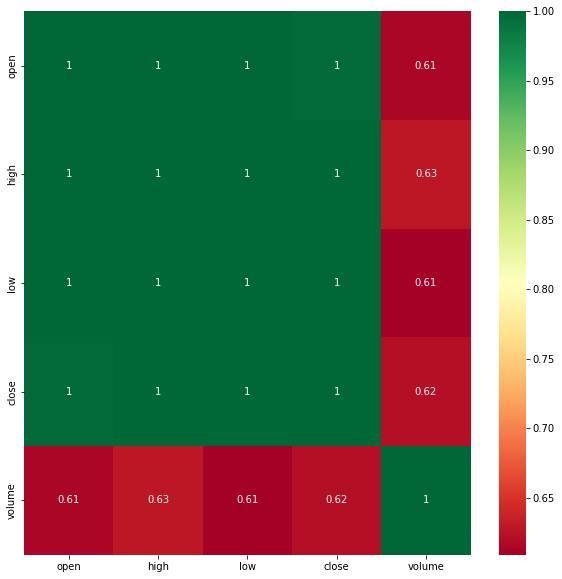

In [4]:
#get correlations of each features in dataset
df = STB.drop('date', axis=1)
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(STB[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Preprocessing Data¶

In [5]:
STB.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [6]:
STB.isna().any()

date      False
open      False
high      False
low       False
close     False
volume    False
dtype: bool

In [7]:
# STB.dropna(inplace=True)
# STB.isna().any()
# no need because STB dont have any value null or not a number

# Checking datatype of each column¶


In [8]:
# Checking Data type of each column
print("Date column data type: ", type(STB['date'][0]))
print("Open column data type: ", type(STB['open'][0]))
print("Close column data type: ", type(STB['close'][0]))
print("High column data type: ", type(STB['high'][0]))
print("Low column data type: ", type(STB['low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.int64'>
Close column data type:  <class 'numpy.int64'>
High column data type:  <class 'numpy.int64'>
Low column data type:  <class 'numpy.int64'>


# Convert date from string to date format


In [9]:
# convert date field from string to Date format and make it index
STB['date'] = pd.to_datetime(STB.date)
STB.head()

,date,open,high,low,close,volume
0,2016-01-04,12700,12800,12300,12600,1127820
1,2016-01-05,12600,12600,12300,12300,332490
2,2016-01-06,12400,12900,12400,12800,1267100
3,2016-01-07,12700,12800,12400,12600,835460
4,2016-01-08,12600,12700,12300,12600,452540


. Sorting dataset by date format¶


In [10]:
STB.sort_values(by='date', inplace=True)
STB

,date,open,high,low,close,volume
0,2016-01-04,12700,12800,12300,12600,1127820
1,2016-01-05,12600,12600,12300,12300,332490
2,2016-01-06,12400,12900,12400,12800,1267100
3,2016-01-07,12700,12800,12400,12600,835460
4,2016-01-08,12600,12700,12300,12600,452540
...,...,...,...,...,...,...
1722,2022-11-21,17300,17400,16700,16700,17502900
1723,2022-11-22,16600,17800,16600,16900,30775500
1724,2022-11-23,16900,17900,16900,17500,25665600
1725,2022-11-24,17300,18200,16900,18200,18314400


In [11]:
STB.shape

(1727, 6)

# EDA - Exploratory Data Analysis



Get the duration of dataset


In [12]:
print("Starting date: ",STB.iloc[0][0])
print("Ending date: ", STB.iloc[-1][0])
print("Duration: ", STB.iloc[-1][0]-STB.iloc[0][0])

Starting date:  2016-01-04 00:00:00
Ending date:  2022-11-25 00:00:00
Duration:  2517 days 00:00:00


Monthwise comparision between Stock actual, open and close price


In [13]:
monthvise= STB.groupby(STB['date'].dt.strftime('%B'))[['open','close']].mean().sort_values(by='close')
monthvise

,open,close
date,,
October,14492.091503,14427.516340
November,14509.731544,14521.275168
December,14871.374046,14887.633588
September,15014.680851,14989.716312
May,15299.310345,15331.241379
July,15589.215686,15573.006536
August,15696.178344,15670.382166
January,15799.197080,15852.408759
February,15860.258621,15870.000000


In [14]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock actual, open and close price')
fig.show()

Monthwise High and Low stock price


In [15]:
STB.groupby(STB['date'].dt.strftime('%B'))['low'].min()


date
April         7200
August       10000
December      7360
February      9760
January       8200
July          9670
June         10350
March         7120
May           8930
November      7380
October       8760
September     9300
Name: low, dtype: int64

In [16]:
monthvise_high= STB.groupby(STB['date'].dt.strftime('%B'))['high'].max()
monthvise_low= STB.groupby(STB['date'].dt.strftime('%B'))['low'].min()

In [17]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

Trend comparision between stock price, open price, close price, high price, low price¶


In [18]:
from itertools import cycle
import plotly.express as px

names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(STB, x=STB.date, y=[STB['open'], STB['close'], 
                                          STB['high'], STB['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Close price prediction preparation and preprocessing¶



Make separate dataframe with close price


In [19]:
closedf = STB[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1727, 2)


Plotting stock close price chart


In [20]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Normalizing / scaling close value between 0 to 1


In [21]:
close_stock = closedf.copy()
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1727, 1)


Split data for training and testing


In [22]:
training_size=int(len(closedf)*0.8)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1381, 1)
test_data:  (346, 1)


Create new dataset according to requirement of time-series prediction


In [23]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1360, 20)
y_train:  (1360,)
X_test:  (325, 20)
y_test (325,)


# RF

In [25]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100,random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [26]:
# Lets Do the prediction 

RF_train_predict=regressor.predict(X_train)
RF_test_predict=regressor.predict(X_test)
# print("Train data prediction:", train_predict)
# # print("Test data prediction:", test_predict)
RF_train_predict = RF_train_predict.reshape(-1,1)
RF_test_predict = RF_test_predict.reshape(-1,1)

print("Train data prediction:", RF_train_predict.shape)
print("Test data prediction:", RF_test_predict.shape)

Train data prediction: (1360, 1)
Test data prediction: (325, 1)


In [27]:
# Transform back to original form

RF_train_predict = scaler.inverse_transform(RF_train_predict)
RF_test_predict = scaler.inverse_transform(RF_test_predict)
RF_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
RF_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [28]:
# Evaluation metrices RMSE and MAE
RF_RMSE_train = math.sqrt(mean_squared_error(RF_original_ytrain,RF_train_predict))
RF_MSE_train = mean_squared_error(RF_original_ytrain,RF_train_predict)
RF_MAE_train = mean_absolute_error(RF_original_ytrain,RF_train_predict)

RF_RMSE_test = math.sqrt(mean_squared_error(RF_original_ytest,RF_test_predict))
RF_MSE_test = mean_squared_error(RF_original_ytest,RF_test_predict)
RF_MAE_test = mean_absolute_error(RF_original_ytest,RF_test_predict)

print("Train data RMSE: ", RF_RMSE_train)
print("Train data MSE: ", RF_MSE_train)
print("Test data MAE: ", RF_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", RF_RMSE_test)
print("Test data MSE: ", RF_MSE_test)
print("Test data MAE: ", RF_MAE_test)

Train data RMSE:  139.61833240175525
Train data MSE:  19493.278742647024
Test data MAE:  90.08610294117662
-------------------------------------------------------------------------------------
Test data RMSE:  2244.7817238413877
Test data MSE:  5039044.987692312
Test data MAE:  1829.7723076923087


Explained variance regression score
The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [29]:
RF_EV_train = explained_variance_score(RF_original_ytrain, RF_train_predict)
RF_EV_test = explained_variance_score(RF_original_ytest, RF_test_predict)

print("Train data explained variance regression score:", RF_EV_train)
print("Test data explained variance regression score:", RF_EV_test)

Train data explained variance regression score: 0.998854621705229
Test data explained variance regression score: 0.8368139184984686


R2 score for regression
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best
0 or < 0 = worse

In [30]:
RF_r2_train = r2_score(RF_original_ytrain, RF_train_predict)
RF_r2_test = r2_score(RF_original_ytest, RF_test_predict)

print("Train data R2 score:", RF_r2_train)
print("Test data R2 score:", RF_r2_test)

Train data R2 score: 0.9988545643106118
Test data R2 score: 0.8132154001363552


Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)¶


In [31]:
RF_MGD_train = mean_gamma_deviance(RF_original_ytrain, RF_train_predict)
RF_MGD_test = mean_gamma_deviance(RF_original_ytest, RF_test_predict)
RF_MPD_train = mean_poisson_deviance(RF_original_ytrain, RF_train_predict)
RF_MPD_test = mean_poisson_deviance(RF_original_ytest, RF_test_predict)
print("Train data MGD: ", RF_MGD_train)
print("Test data MGD: ", RF_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", RF_MPD_train)
print("Test data MPD: ",RF_MPD_test)

Train data MGD:  9.296872403353963e-05
Test data MGD:  0.006837849555938887
----------------------------------------------------------------------
Train data MPD:  1.2611200966062839
Test data MPD:  183.90328241962024


Comparision between original stock close price vs predicted close price¶


In [51]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(RF_train_predict)+look_back, :] = RF_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(RF_train_predict)+(look_back*2)+1:len(closedf)-1, :] = RF_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1727, 1)
Test predicted data:  (1727, 1)


# Predicting next 10 days


In [33]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = regressor.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = regressor.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


Plotting last 15 days and next predicted 10 days


In [34]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [35]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Plotting whole closing stock price with prediction¶


In [36]:
rfdf=closedf.tolist()
rfdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
rfdf=scaler.inverse_transform(rfdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rfdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# RF + Optuna

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import optuna

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'])
    random_state = 42

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        random_state=random_state
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Use Optuna to optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Optuna: ", best_params)

regressor_optuna = RandomForestRegressor(**best_params)
regressor_optuna.fit(X_train, y_train)

[I 2023-04-23 12:08:11,886] A new study created in memory with name: no-name-7ee7a869-3edc-416b-80ac-b460a8b62be6
[I 2023-04-23 12:08:25,988] Trial 0 finished with value: 0.005519419626241186 and parameters: {'n_estimators': 544, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'auto', 'bootstrap': True, 'criterion': 'poisson'}. Best is trial 0 with value: 0.005519419626241186.
[I 2023-04-23 12:08:38,146] Trial 1 finished with value: 0.007557318731059515 and parameters: {'n_estimators': 939, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'poisson'}. Best is trial 0 with value: 0.005519419626241186.
[I 2023-04-23 12:08:41,404] Trial 2 finished with value: 0.007295078208987779 and parameters: {'n_estimators': 202, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 0.0055

Optuna:  {'n_estimators': 626, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'auto', 'bootstrap': False, 'criterion': 'absolute_error'}


RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=7,
                      max_features='auto', min_samples_leaf=8,
                      min_samples_split=9, n_estimators=626)

In [38]:
# Lets Do the prediction 

OP_train_predict=regressor_optuna.predict(X_train)
OP_test_predict=regressor_optuna.predict(X_test)

OP_train_predict = OP_train_predict.reshape(-1,1)
OP_test_predict = OP_test_predict.reshape(-1,1)

print("Train data prediction:", OP_train_predict.shape)
print("Test data prediction:", OP_test_predict.shape)

Train data prediction: (1360, 1)
Test data prediction: (325, 1)


In [39]:
# Transform back to original form

OP_train_predict = scaler.inverse_transform(OP_train_predict)
OP_test_predict = scaler.inverse_transform(OP_test_predict)
OP_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
OP_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [40]:
# Evaluation metrices RMSE and MAE
OP_RMSE_train = math.sqrt(mean_squared_error(OP_original_ytrain,OP_train_predict))
OP_MSE_train = mean_squared_error(OP_original_ytrain,RF_train_predict)
OP_MAE_train = mean_absolute_error(OP_original_ytrain,OP_train_predict)
OP_RMSE_test = math.sqrt(mean_squared_error(RF_original_ytest,OP_test_predict))
OP_MSE_test = mean_squared_error(OP_original_ytest,OP_test_predict)
OP_MAE_test = mean_absolute_error(OP_original_ytest,OP_test_predict)

print("Train data RMSE: ", OP_RMSE_train)
print("Train data MSE: ", OP_MSE_train)
print("Test data MAE: ", OP_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", OP_RMSE_test)
print("Test data MSE: ", OP_MSE_test)
print("Test data MAE: ", OP_MAE_test)

Train data RMSE:  327.5984000795049
Train data MSE:  19493.278742647024
Test data MAE:  193.88856652885343
-------------------------------------------------------------------------------------
Test data RMSE:  1859.40175885993
Test data MSE:  3457374.900851401
Test data MAE:  1437.7822560825152


In [41]:
OP_EV_train = explained_variance_score(OP_original_ytrain, OP_train_predict)
OP_EV_test = explained_variance_score(OP_original_ytest, OP_test_predict)

print("Train data explained variance regression score:", OP_EV_train)
print("Test data explained variance regression score:", OP_EV_test)

Train data explained variance regression score: 0.9936978589016624
Test data explained variance regression score: 0.8942499385208046


In [42]:
OP_r2_train = r2_score(OP_original_ytrain, OP_train_predict)
OP_r2_test = r2_score(OP_original_ytest, OP_test_predict)

print("Train data R2 score:", OP_r2_train)
print("Test data R2 score:", OP_r2_test)

Train data R2 score: 0.9936937764521641
Test data R2 score: 0.8718438932354359


In [43]:
OP_MGD_train = mean_gamma_deviance(OP_original_ytrain, OP_train_predict)
OP_MGD_test = mean_gamma_deviance(OP_original_ytest, OP_test_predict)
OP_MPD_train = mean_poisson_deviance(OP_original_ytrain, OP_train_predict)
OP_MPD_test = mean_poisson_deviance(OP_original_ytest, OP_test_predict)
print("Train data MGD: ", OP_MGD_train)
print("Test data MGD: ", OP_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", OP_MPD_train)
print("Test data MPD: ",OP_MPD_test)

Train data MGD:  0.0004781304787841871
Test data MGD:  0.004721003845756461
----------------------------------------------------------------------
Train data MPD:  6.6821851762310684
Test data MPD:  126.59227940734002


In [49]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(OP_train_predict)+look_back, :] = OP_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(OP_train_predict)+(look_back*2)+1:len(closedf)-1, :] = OP_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1727, 1)
Test predicted data:  (1727, 1)


In [45]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = regressor_optuna.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = regressor_optuna.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [46]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [47]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [50]:
opdf=closedf.tolist()
opdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
opdf=scaler.inverse_transform(opdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rfdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()